# En este notebook se entrena la red neuronal para resolver la ecuación del calor estocástica en 1D para múltiples omegas
___

## Importar librerías

In [1]:
import sys
import numpy as np
import pickle as pkl
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
from matplotlib import animation
from IPython.display import HTML
import random

In [2]:
colab = True
if colab:
    from google.colab import drive

    drive.mount("/content/drive")
    main_path = "/content/drive/MyDrive/SB/"

    !git clone --depth 1 https://github.com/davidnfu0/NN_SPDEs.git
    !cp -r NN_SPDEs/Código/src ./src
    !rm -rf NN_SPDEs

    sys.path.append("src")

else:
    main_path = "files/"
    sys.path.append("src")

from src.NeuralNetwork import NeuralNetwork

Mounted at /content/drive
Cloning into 'NN_SPDEs'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 31 (delta 0), reused 20 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 254.63 KiB | 1.33 MiB/s, done.


___

## Importar el Alpha Set

In [3]:
I, J, K, n, T, normals = 1, 5, 1, 20, 1, 2

# Editar el nombre del archivo de datos si es particular
filename = f"files/alpha_set_I{I}_J{J}_K{K}_n{n}_T{T}_Normals{normals}.pkl"
if not os.path.exists(filename):
    print(f"Primero se tiene que crear el archivo '{filename}'")
else:
    alpha_set = pkl.load(open(filename, "rb"))

experiment_folder = f"heat_add_1d_I{I}_J{J}_K{K}_n{n}_T{T}_Normals{normals}"
experiment_path = os.path.join(main_path, experiment_folder)
os.makedirs(experiment_path, exist_ok=True)
main_path = main_path + experiment_folder + "/"

___

## Crear dominio, función de pérdida y condición inicial

In [4]:
# Definir el dominio sobre el cual se va a trabajar
np.random.seed(97)
space_domain = np.random.normal(size=(1, 200))[0]

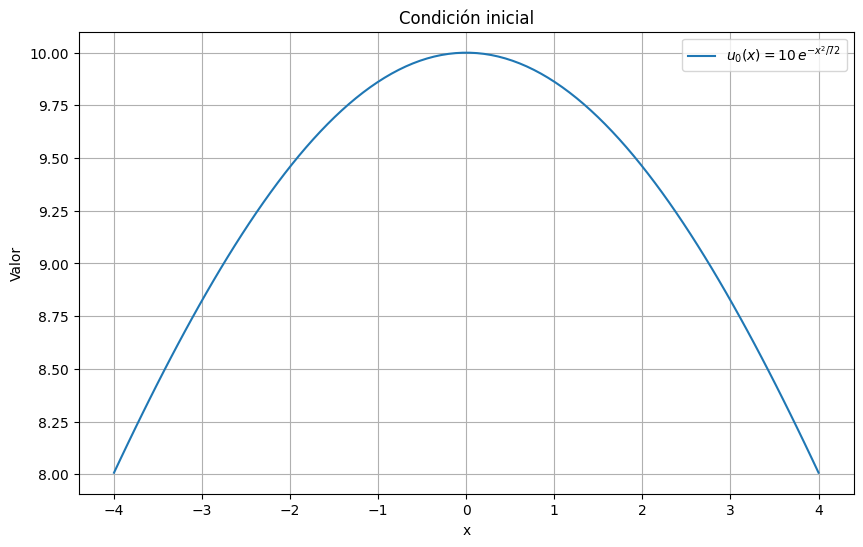

In [5]:
def initial_condition(x: torch.Tensor) -> torch.Tensor:
    return 10 * torch.exp(-(x**2) / 72)


# Visualizar la condición inicial
plt.figure(figsize=(10, 6))
x = np.linspace(-4, 4, 100)
y = initial_condition(torch.tensor(x, dtype=torch.float32)).numpy()
plt.plot(x, y, label=r"$u_0(x) = 10\, e^{-x^2/72}$")
plt.title("Condición inicial")
plt.xlabel("x")
plt.ylabel("Valor")
plt.grid()
plt.legend()
plt.savefig(main_path + "initial_condition_heat_1d_paper.pdf")
plt.show()


In [6]:
def loss_function(model, space_domain, initial_condition):
    """
    Función de pérdida para entrenar la red neuronal en el contexto de una SPDE.
    Esta función calcula la pérdida basada en la ecuación estocástica parcial diferencial (SPDE)
    para la ecuación del calor con ruido aditivo.

    Args:
        model (NeuralNetwork): La red neuronal que se está entrenando.
        space_domain (torch.Tensor): El dominio del espacio donde se evalúa la solución.
        initial_condition (function): La función que define la condición inicial del problema.

    Returns:
        torch.Tensor: El valor de la función de pérdida, que es la norma cuadrática del residuo de la SPDE.
    """
    # Detectar el dispositivo disponible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Poner el modelo en modo evaluación y mover al dispositivo
    model.eval()
    model.to(device)

    # ---------------------------------------------------------
    # Preparación: malla temporal y espacial
    # ---------------------------------------------------------
    t_interval = model.t
    t = torch.tensor(t_interval, dtype=torch.float32, device=device)

    dt = torch.tensor([t[1]], device=device)
    n = len(t)
    m = torch.tensor(range(1, n + 1), device=device)

    x = torch.tensor(space_domain, dtype=torch.float32, device=device)

    # Producto cartesiano
    Omega_t = torch.cartesian_prod(t, x).to(device).requires_grad_()
    Omega_dt = torch.cartesian_prod(dt, x).to(device).requires_grad_()

    # ---------------------------------------------------------
    # Evaluación de la red
    # ---------------------------------------------------------
    U_t = model(Omega_t)
    U_dt = model(Omega_dt)

    # Derivadas espaciales
    Ux_dt = torch.autograd.grad(
        U_dt,
        Omega_dt,
        grad_outputs=torch.ones_like(U_dt),
        create_graph=True,
    )[0][:, 1]  # ∂_x X

    Uxx_dt = torch.autograd.grad(
        Ux_dt,
        Omega_dt,
        grad_outputs=torch.ones_like(Ux_dt),
        create_graph=True,
    )[0][:, 1]  # ∂_{xx} X

    AX_term = torch.kron(m, Uxx_dt)

    # Ruido aditivo (incrementos de Brown)
    brownian_paths = (model.alpha_set.brownian_paths[model.omega])[0]
    paths_tensor = torch.tensor(brownian_paths, dtype=U_t.dtype, device=device)
    paths_tensor = paths_tensor.unsqueeze(1).repeat(1, len(space_domain)).reshape(-1)

    # Condición inicial
    initial_sol = initial_condition(x)
    initial_sol_tensor = torch.tensor(initial_sol, dtype=U_t.dtype, device=device)
    initial_sol_tensor_expanded = initial_sol_tensor.repeat(n)

    # Residuo
    residual = U_t - initial_sol_tensor_expanded - AX_term - paths_tensor

    # Función de pérdida
    return nn.MSELoss()(residual, torch.zeros_like(U_t))

___

## Entrenar la red neuronal

In [7]:
n_layers = 1  # Número de capas ocultas
wide = 75  # Ancho de las capas ocultas
activation = nn.Tanh  # Función de activación
epochs = 8*10**4  # Número de épocas de entrenamiento
optimizer = optim.Adam  # Optimizador
lr = 2*10**(-3)  # Tasa de aprendizaje
n_normals_to_train = 1  # Número de normales a entrenar en cada época
n_normals_batch_size = 1  # Tamaño del batch de normales a entrenar

In [8]:
# Guardar los parámetros de la red en un archivo txt en main_path
params_txt = os.path.join(main_path, "parametros_red.txt")
with open(params_txt, "w") as f:
    f.write(f"J: {J}\n")
    f.write(f"K: {K}\n")
    f.write(f"Total normals: {normals}\n")
    f.write(f"n_layers: {n_layers}\n")
    f.write(f"wide: {wide}\n")
    f.write(f"activation: {activation.__name__}\n")
    f.write(f"epochs: {epochs}\n")
    f.write(f"optimizer: {optimizer.__name__}\n")
    f.write(f"lr: {lr}\n")
    f.write(f"n_normals_to_train: {n_normals_to_train}\n")
    f.write(f"n_normals_batch_size: {n_normals_batch_size}\n")
print(f"Archivo de parámetros guardado en: {params_txt}")

Archivo de parámetros guardado en: /content/drive/MyDrive/SB/heat_add_1d_I1_J5_K1_n20_T1_Normals2/parametros_red.txt


In [9]:
train = True  # True para entrenar la red, False para cargar un modelo preentrenado

  0%|          | 0/80000 [00:00<?, ?it/s]/tmp/ipython-input-6-3715883126.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(space_domain, dtype=torch.float32, device=device)
/tmp/ipython-input-6-3715883126.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_sol_tensor = torch.tensor(initial_sol, dtype=U_t.dtype, device=device)
Epoch [80000/80000] | Loss: 0.0000 | Best Loss: 0.0000:   0%|          | 0/80000 [18:03<?, ?it/s]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

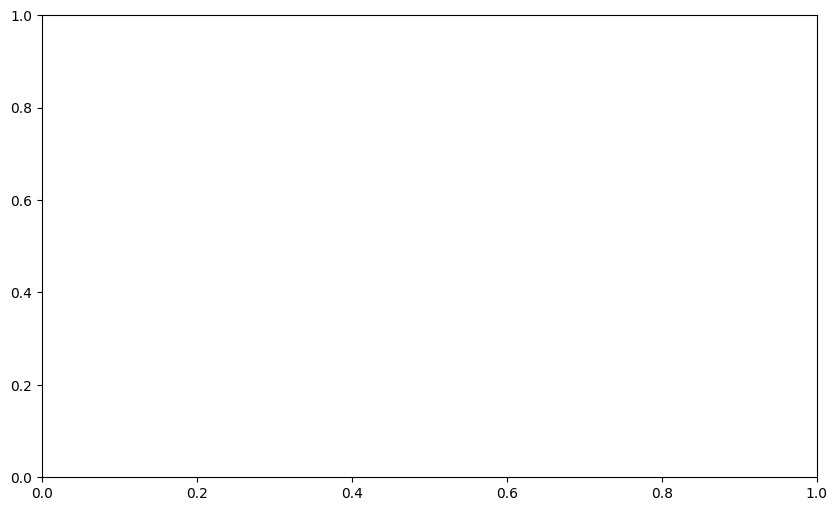

In [10]:
if train:
    # Definir modelo
    nn_model = NeuralNetwork(
        space_dim=1,
        alpha_set=alpha_set,
        n_layers=n_layers,
        wide=wide,
        activation=activation,
    )

    # Detectar plataforma
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    platform_str = f"Plataforma: {device.type.upper()}"

    # Medir tiempo de entrenamiento
    start_time = time.time()
    loss_list = nn_model.train_model(
        space_domain=space_domain,
        loss_function=loss_function,
        initial_condition=initial_condition,
        epochs=epochs,
        optimizer=optimizer,
        lr=lr,
        model_name="params",
        n_normals_to_train=n_normals_to_train,
        n_normals_batch_size=n_normals_batch_size,
    )
    elapsed_time = time.time() - start_time

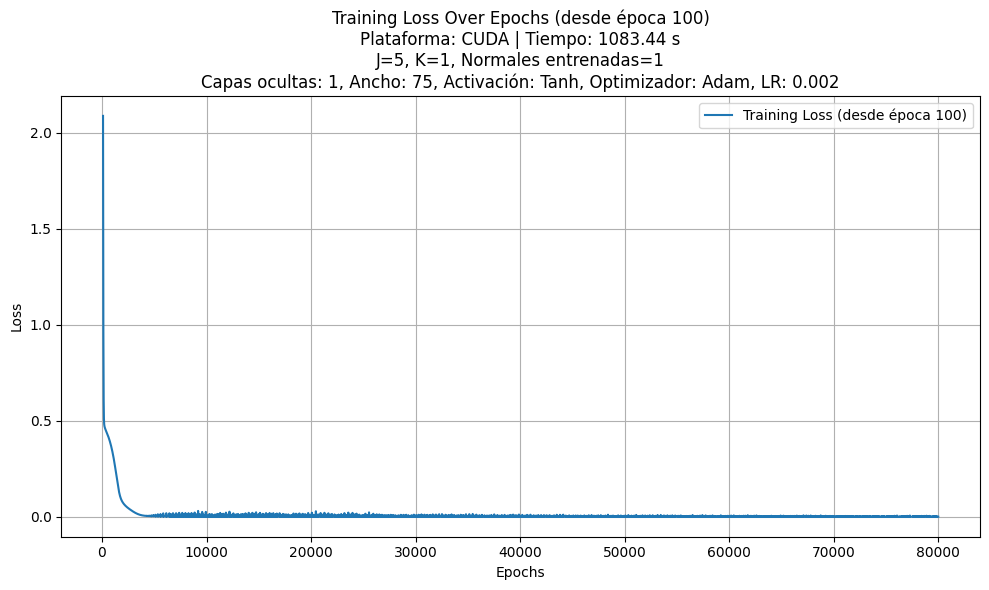

In [20]:
if train:
    # Visualizar la pérdida durante el entrenamiento a partir de la época 100
    loss_list_cpu = []
    for loss in loss_list:
        loss_list_cpu.append(loss.detach().cpu().numpy())
    plt.figure(figsize=(10, 6))
    plt.plot(
        range(100, len(loss_list_cpu)),
        loss_list_cpu[100:],
        label="Training Loss (desde época 100)",
    )
    title_str = (
        f"Training Loss Over Epochs (desde época 100)\n"
        f"{platform_str} | Tiempo: {elapsed_time:.2f} s\n"
        f"J={J}, K={K}, Normales entrenadas={n_normals_to_train}\n"
        f"Capas ocultas: {n_layers}, Ancho: {wide}, "
        f"Activación: {activation.__name__}, Optimizador: {optimizer.__name__}, LR: {lr}"
    )
    plt.title(title_str)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    filename_loss = (
        main_path
        + f"heat_1d_paper_training_loss_from_100_J{J}_K{K}_N{n_normals_to_train}.pdf"
    )
    plt.savefig(filename_loss)
    plt.show()

    # Guardar el modelo entrenado
    torch.save(nn_model.state_dict(), main_path + "params.txt")

In [15]:
if not train:
    # Cargar el modelo preentrenado
    if not os.path.exists(main_path + "heat_1d_paper_params.txt"):
        print("Primero se tiene que crear el archivo 'heat_1d_paper_params.txt'")
    else:
        nn_model = NeuralNetwork(
            space_dim=1,
            alpha_set=alpha_set,
            n_layers=n_layers,
            wide=wide,
            activation=activation,
        )
        nn_model.load_state_dict(torch.load(main_path + "heat_1d_paper_params.txt"))
        nn_model.eval()
        print("Modelo cargado")

___

## Evaluar el modelo

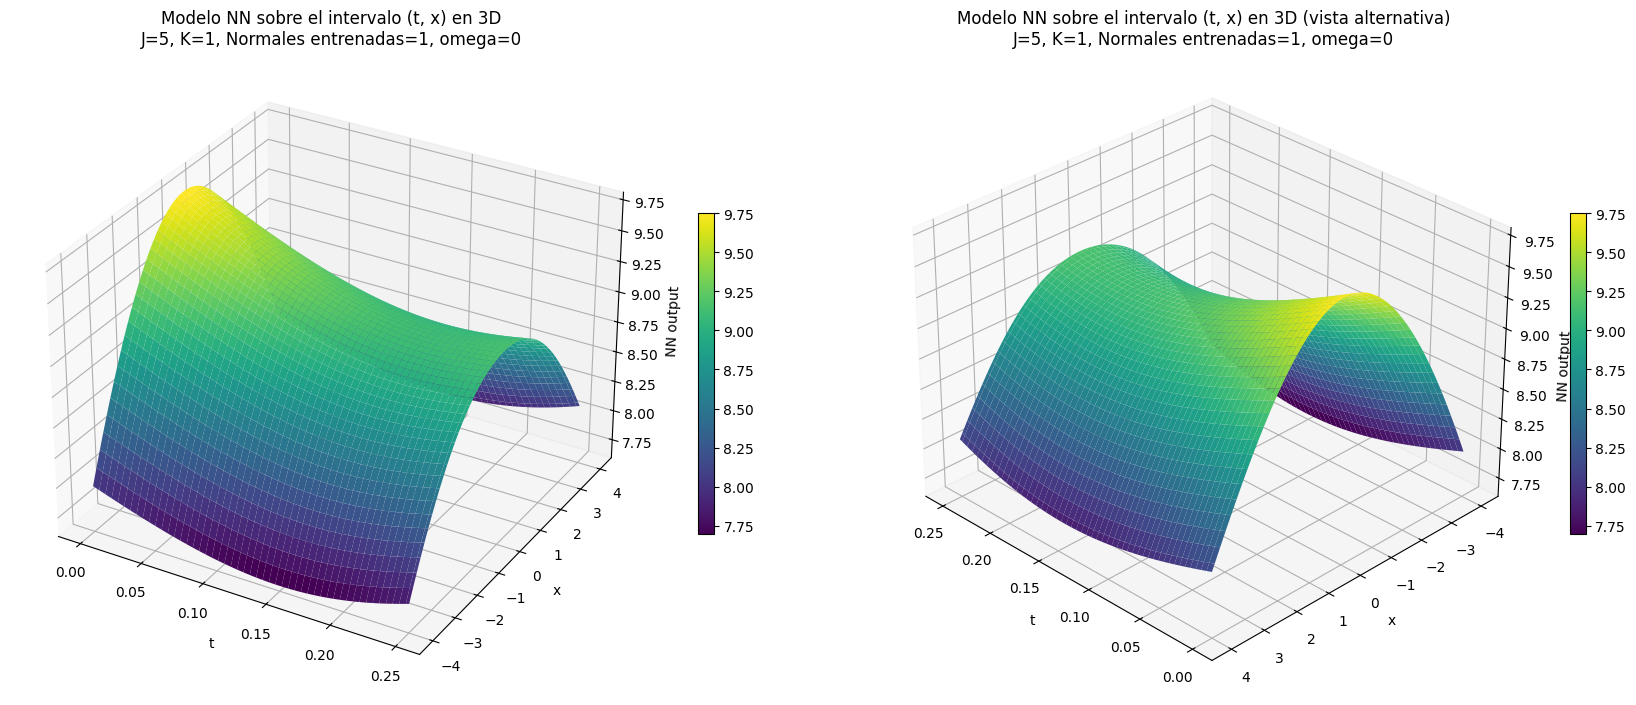

In [11]:
# Selección el omega para evaluar la red neuronal
omega_eval = 0
nn_model.omega = omega_eval

# Crear la grilla de puntos (t, x) para evaluar la red neuronal
t_points = np.linspace(0, 0.25, 100)
x_points = np.linspace(-4, 4, 100)
t_grid, x_grid = np.meshgrid(t_points, x_points)
input_tensor = torch.tensor(
    np.stack([t_grid.ravel(), x_grid.ravel()], axis=1), dtype=torch.float32
)

# Calcular la salida de    # dt = dt.repeat(n)  # vector (Δt,…,Δt) la red neuronal
with torch.no_grad():
    output = nn_model(input_tensor).cpu().numpy().reshape(t_grid.shape)


# Crear una figura con dos subplots para mostrar ambas perspectivas
fig = plt.figure(figsize=(18, 7))

# Perspectiva 1: vista estándar
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
surf1 = ax1.plot_surface(t_grid, x_grid, output, cmap="viridis")
fig.colorbar(surf1, ax=ax1, shrink=0.5)
ax1.set_xlabel("t")
ax1.set_ylabel("x")
ax1.set_zlabel("NN output")
ax1.set_title(
    f"Modelo NN sobre el intervalo (t, x) en 3D\nJ={J}, K={K}, Normales entrenadas={n_normals_to_train}, omega={omega_eval}"
)

# Perspectiva 2: vista desde otro ángulo
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
surf2 = ax2.plot_surface(t_grid, x_grid, output, cmap="viridis")
fig.colorbar(surf2, ax=ax2, shrink=0.5)
ax2.set_xlabel("t")
ax2.set_ylabel("x")
ax2.set_zlabel("NN output")
ax2.set_title(
    f"Modelo NN sobre el intervalo (t, x) en 3D (vista alternativa)\nJ={J}, K={K}, Normales entrenadas={n_normals_to_train}, omega={omega_eval}"
)
ax2.view_init(elev=30, azim=135)  # Cambia el ángulo de vista

plt.tight_layout()
plt.savefig(
    main_path
    + f"heat_1d_paper_nn_output_both_views_J{J}_K{K}_N{n_normals_to_train}_omega{omega_eval}.pdf"
)
plt.show()

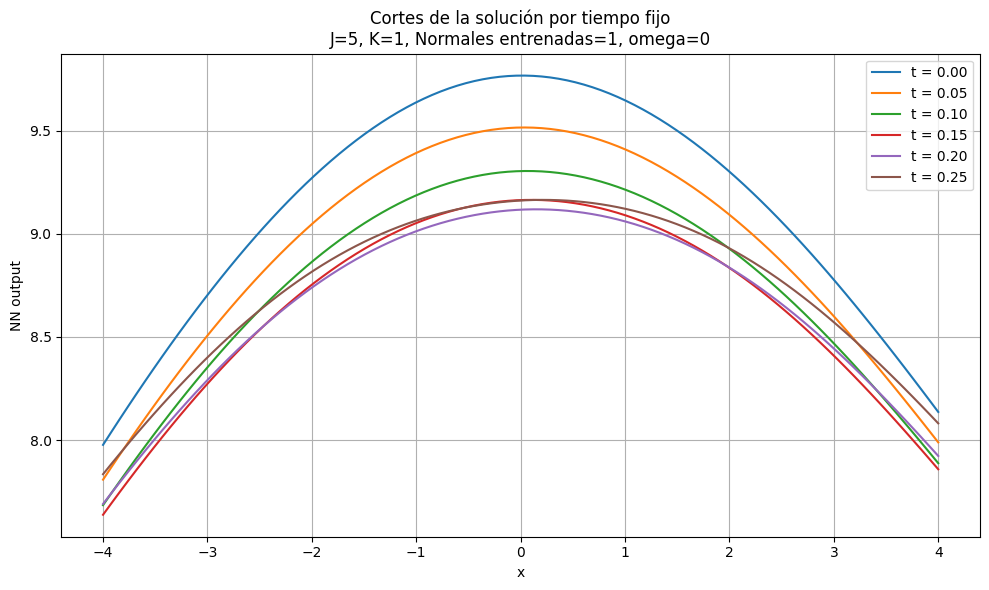

In [12]:
# Elegir algunos tiempos fijos para mostrar los cortes
tiempos_fijos = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25]

plt.figure(figsize=(10, 6))
for t_fijo in tiempos_fijos:
    # Crear el input para la red neuronal: todas las x_points con t fijo
    input_corte = torch.tensor(
        np.stack([np.full_like(x_points, t_fijo), x_points], axis=1),
        dtype=torch.float32,
    )
    with torch.no_grad():
        salida_corte = nn_model(input_corte).cpu().numpy().flatten()
    plt.plot(x_points, salida_corte, label=f"t = {t_fijo:.2f}")
    if t_fijo == 0.0:
        nn_output_t0 = salida_corte

plt.title(
    f"Cortes de la solución por tiempo fijo\nJ={J}, K={K}, Normales entrenadas={n_normals_to_train}, omega={nn_model.omega}"
)
plt.xlabel("x")
plt.ylabel("NN output")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(
    main_path
    + f"heat_1d_paper_nn_output_cortes_tiempo_J{J}_K{K}_N{n_normals_to_train}_omega{nn_model.omega}.pdf"
)
plt.show()

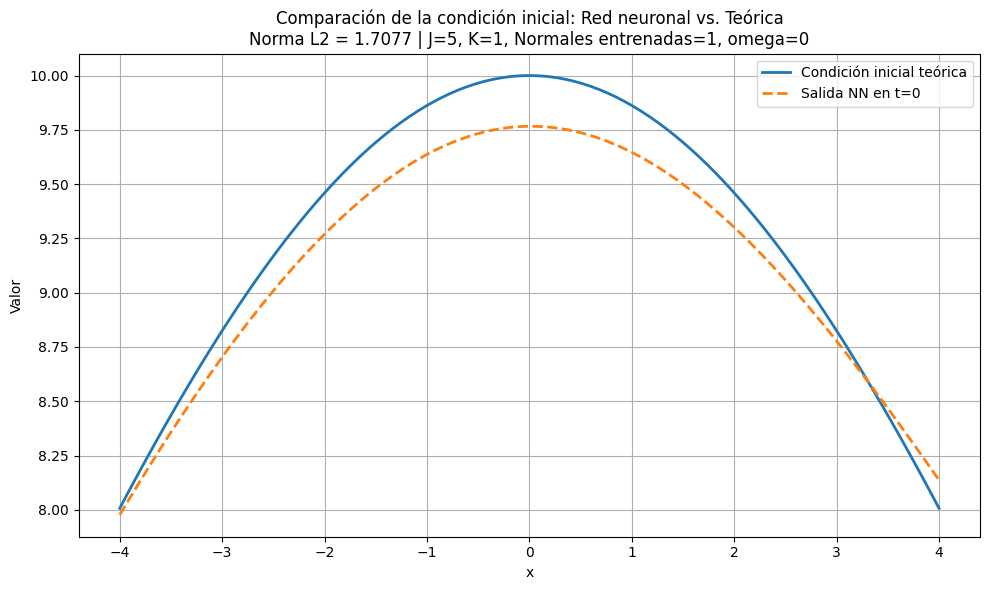

Diferencia en norma L2: 1.707699


In [13]:
initial_cond = initial_condition(torch.tensor(x_points, dtype=torch.float32)).numpy()

# Calcular la diferencia en norma L2
l2_diff = np.linalg.norm(initial_cond - nn_output_t0)

# Graficar comparación
plt.figure(figsize=(10, 6))
plt.plot(x_points, initial_cond, label="Condición inicial teórica", linewidth=2)
plt.plot(x_points, nn_output_t0, "--", label="Salida NN en t=0", linewidth=2)
plt.title(
    f"Comparación de la condición inicial: Red neuronal vs. Teórica\n"
    f"Norma L2 = {l2_diff:.4f} | J={J}, K={K}, Normales entrenadas={n_normals_to_train}, omega={nn_model.omega}"
)
plt.xlabel("x")
plt.ylabel("Valor")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(
    main_path
    + f"heat_1d_paper_nn_vs_initial_condition_J{J}_K{K}_N{n_normals_to_train}.pdf"
)
plt.show()

print(f"Diferencia en norma L2: {l2_diff:.6f}")

Animación guardada como GIF en: /content/drive/MyDrive/SB/heat_add_1d_I1_J5_K1_n20_T1_Normals2/heat_1d_paper_nn_anim_J5_K1_N1.gif


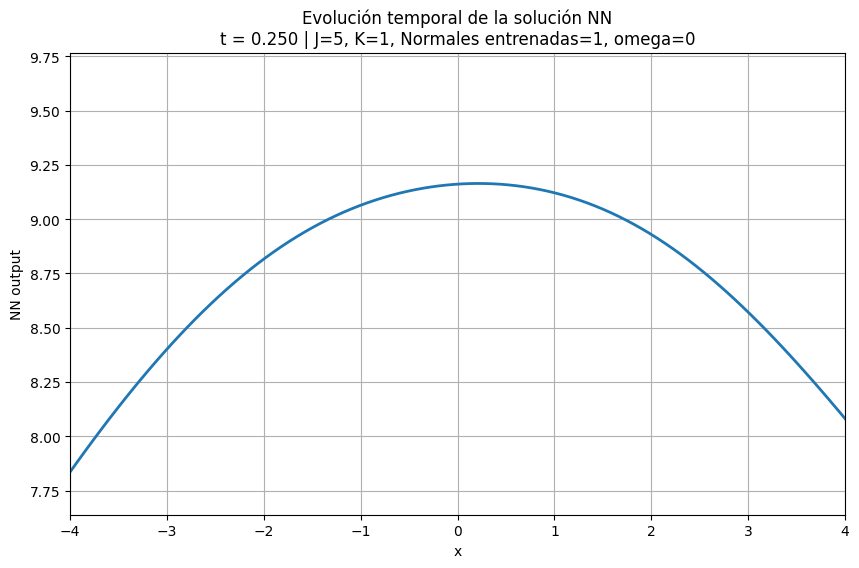

In [14]:
# Crear la figura y el eje
fig_anim, ax_anim = plt.subplots(figsize=(10, 6))
(line,) = ax_anim.plot([], [], lw=2)
ax_anim.set_xlim(x_points.min(), x_points.max())
ax_anim.set_ylim(output.min(), output.max())
ax_anim.set_xlabel("x")
ax_anim.set_ylabel("NN output")
ax_anim.set_title(
    f"Evolución temporal de la solución NN\nJ={J}, K={K}, Normales entrenadas={n_normals_to_train}"
)
ax_anim.grid()


# Función de inicialización
def init():
    line.set_data([], [])
    return (line,)


# Función de animación
def animate(i):
    t_val = t_points[i]
    input_frame = torch.tensor(
        np.stack([np.full_like(x_points, t_val), x_points], axis=1), dtype=torch.float32
    )
    with torch.no_grad():
        y_frame = nn_model(input_frame).cpu().numpy().flatten()
    line.set_data(x_points, y_frame)
    ax_anim.set_title(
        f"Evolución temporal de la solución NN\n"
        f"t = {t_val:.3f} | J={J}, K={K}, Normales entrenadas={n_normals_to_train}, omega={nn_model.omega}"
    )
    return (line,)


# Crear la animación
ani = animation.FuncAnimation(
    fig_anim, animate, frames=len(t_points), init_func=init, blit=True, interval=60
)

# Mostrar la animación en Jupyter
HTML(ani.to_jshtml())

# Guardar la animación como GIF
gif_filename = f"{main_path}heat_1d_paper_nn_anim_J{J}_K{K}_N{n_normals_to_train}.gif"
ani.save(gif_filename, writer="pillow", fps=20)
print("Animación guardada como GIF en:", gif_filename)

/tmp/ipython-input-6-3715883126.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_sol_tensor = torch.tensor(initial_sol, dtype=U_t.dtype, device=device)


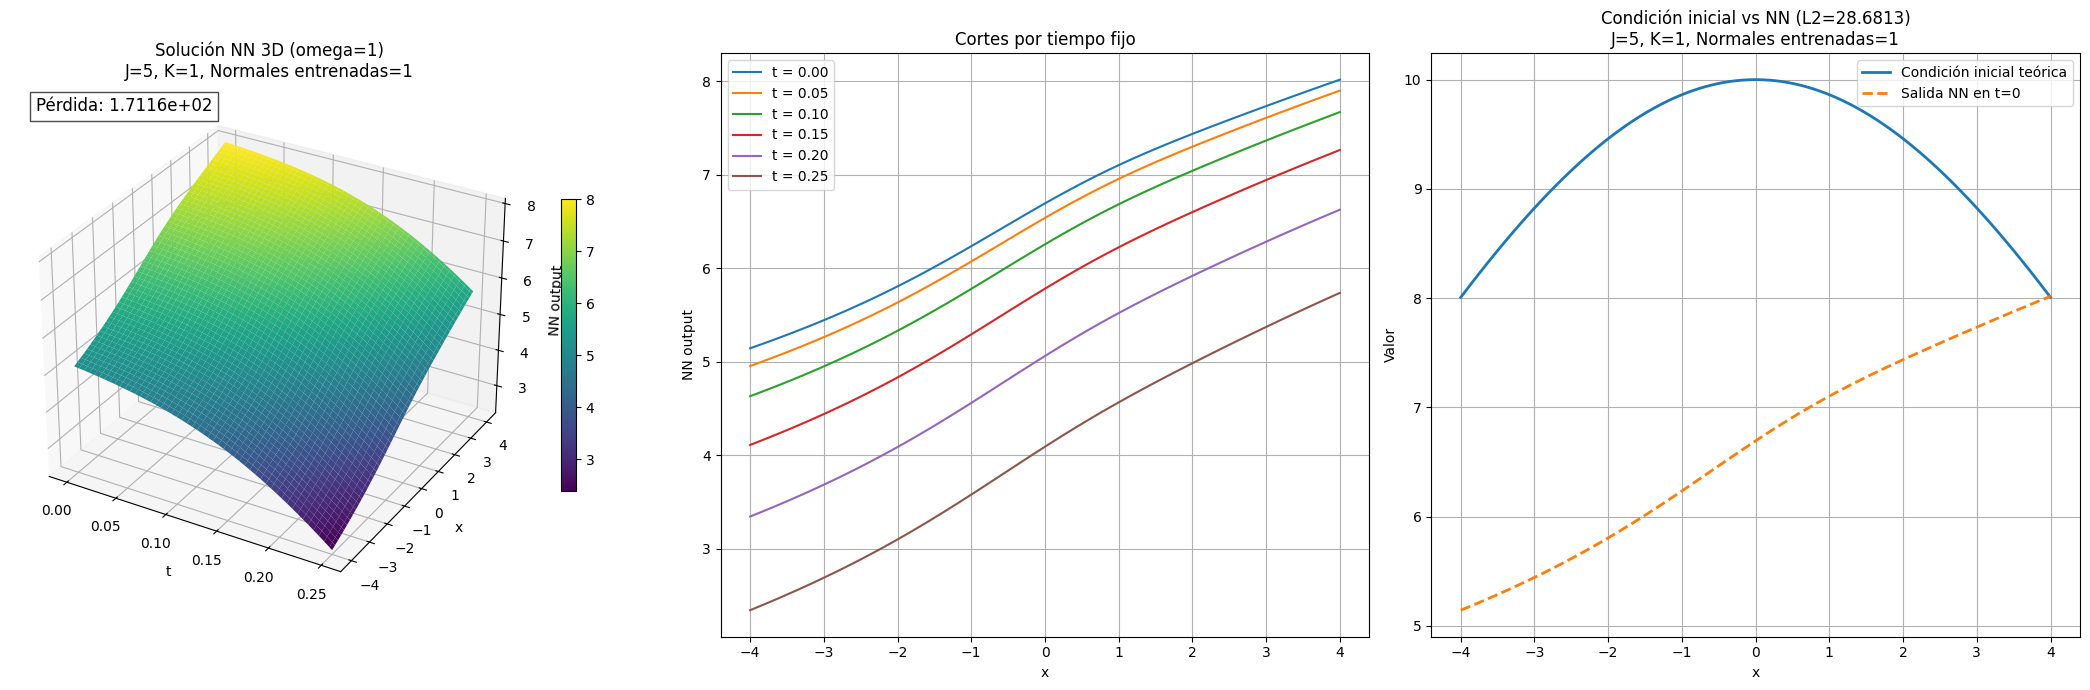

In [21]:
# Dividir los índices de las normales para validación
random.seed(111)
if len(range(n_normals_to_train, normals)) > 5:
    validation_normals_index = random.sample(
        range(n_normals_to_train, normals), 5
    )
else:
    validation_normals_index = range(n_normals_to_train, normals)

for omega in validation_normals_index:
    nn_model.omega = omega

    # Evaluar la red en la grilla (t, x)
    with torch.no_grad():
        output_val = nn_model(input_tensor).cpu().numpy().reshape(t_grid.shape)

    # Graficar la solución 3D
    fig = plt.figure(figsize=(21, 7))
    ax1 = fig.add_subplot(1, 3, 1, projection="3d")
    surf = ax1.plot_surface(t_grid, x_grid, output_val, cmap="viridis")
    fig.colorbar(surf, ax=ax1, shrink=0.5)
    ax1.set_xlabel("t")
    ax1.set_ylabel("x")
    ax1.set_zlabel("NN output")
    ax1.set_title(
        f"Solución NN 3D (omega={omega})\nJ={J}, K={K}, Normales entrenadas={n_normals_to_train}"
    )

    # Calcular la pérdida para este omega
    loss_val = loss_function(nn_model, space_domain, initial_condition).item()
    ax1.text2D(
        0.05,
        0.95,
        f"Pérdida: {loss_val:.4e}",
        transform=ax1.transAxes,
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.7),
    )

    # Graficar cortes en tiempos fijos
    ax2 = fig.add_subplot(1, 3, 2)
    for t_fijo in tiempos_fijos:
        input_corte = torch.tensor(
            np.stack([np.full_like(x_points, t_fijo), x_points], axis=1),
            dtype=torch.float32,
        )
        with torch.no_grad():
            salida_corte = nn_model(input_corte).cpu().numpy().flatten()
        ax2.plot(x_points, salida_corte, label=f"t = {t_fijo:.2f}")
    ax2.set_title("Cortes por tiempo fijo")
    ax2.set_xlabel("x")
    ax2.set_ylabel("NN output")
    ax2.legend()
    ax2.grid()

    # Comparar condición inicial
    input_t0 = torch.tensor(
        np.stack([np.full_like(x_points, 0.0), x_points], axis=1),
        dtype=torch.float32,
    )
    with torch.no_grad():
        nn_output_t0 = nn_model(input_t0).cpu().numpy().flatten()
    l2_diff = np.linalg.norm(initial_cond - nn_output_t0)
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.plot(x_points, initial_cond, label="Condición inicial teórica", linewidth=2)
    ax3.plot(x_points, nn_output_t0, "--", label="Salida NN en t=0", linewidth=2)
    ax3.set_title(
        f"Condición inicial vs NN (L2={l2_diff:.4f})\nJ={J}, K={K}, Normales entrenadas={n_normals_to_train}"
    )
    ax3.set_xlabel("x")
    ax3.set_ylabel("Valor")
    ax3.legend()
    ax3.grid()

    plt.tight_layout()
    plt.savefig(
        main_path
        + f"heat_1d_paper_nn_output_validation_omega_{omega}_J{J}_K{K}_N{n_normals_to_train}.pdf"
    )
    plt.show()

In [22]:
# Calcular la pérdida (loss) para cada omega de validación y mostrar el promedio
loss_errors = []
for omega in range(n_normals_to_train, normals):
    nn_model.omega = omega
    loss_val = loss_function(nn_model, space_domain, initial_condition).item()
    loss_errors.append(loss_val)
    print(f"Omega={omega}: Loss = {loss_val:.4e}")

mean_loss_error = np.mean(loss_errors)
print(f"\nPromedio del loss en validación: {mean_loss_error:.4e}")


Omega=1: Loss = 1.7116e+02

Promedio del loss en validación: 1.7116e+02


/tmp/ipython-input-6-3715883126.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_sol_tensor = torch.tensor(initial_sol, dtype=U_t.dtype, device=device)


___